Run this cell to set all the necessary libraries

In [ ]:
import requests, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy<3.1"
    ! pip install -q "matplotlib<3.6"
    from gwpy.timeseries import TimeSeries   


from gwosc.locate import get_urls

In [ ]:
# Advisable to use drive when downloading all the data
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Initial visualization

To download a GW signal from GWOSC one needs the gps time of the signal and the detector from which to take the signal

In [ ]:
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914

#-- Choose detector as H1, L1, or V1
detector = 'H1'

# Get web info to download the signal
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


Create [time-series](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries) object

In [ ]:
strain = TimeSeries.read(fn,format='hdf5.gwosc')
print(strain)

TimeSeries([1.64458526e-19, 1.70885954e-19, 1.64304597e-19, ...,
            2.73783506e-19, 2.78665378e-19, 2.91918758e-19]
           unit: dimensionless,
           t0: 1126257415.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


Plot the raw time-series data

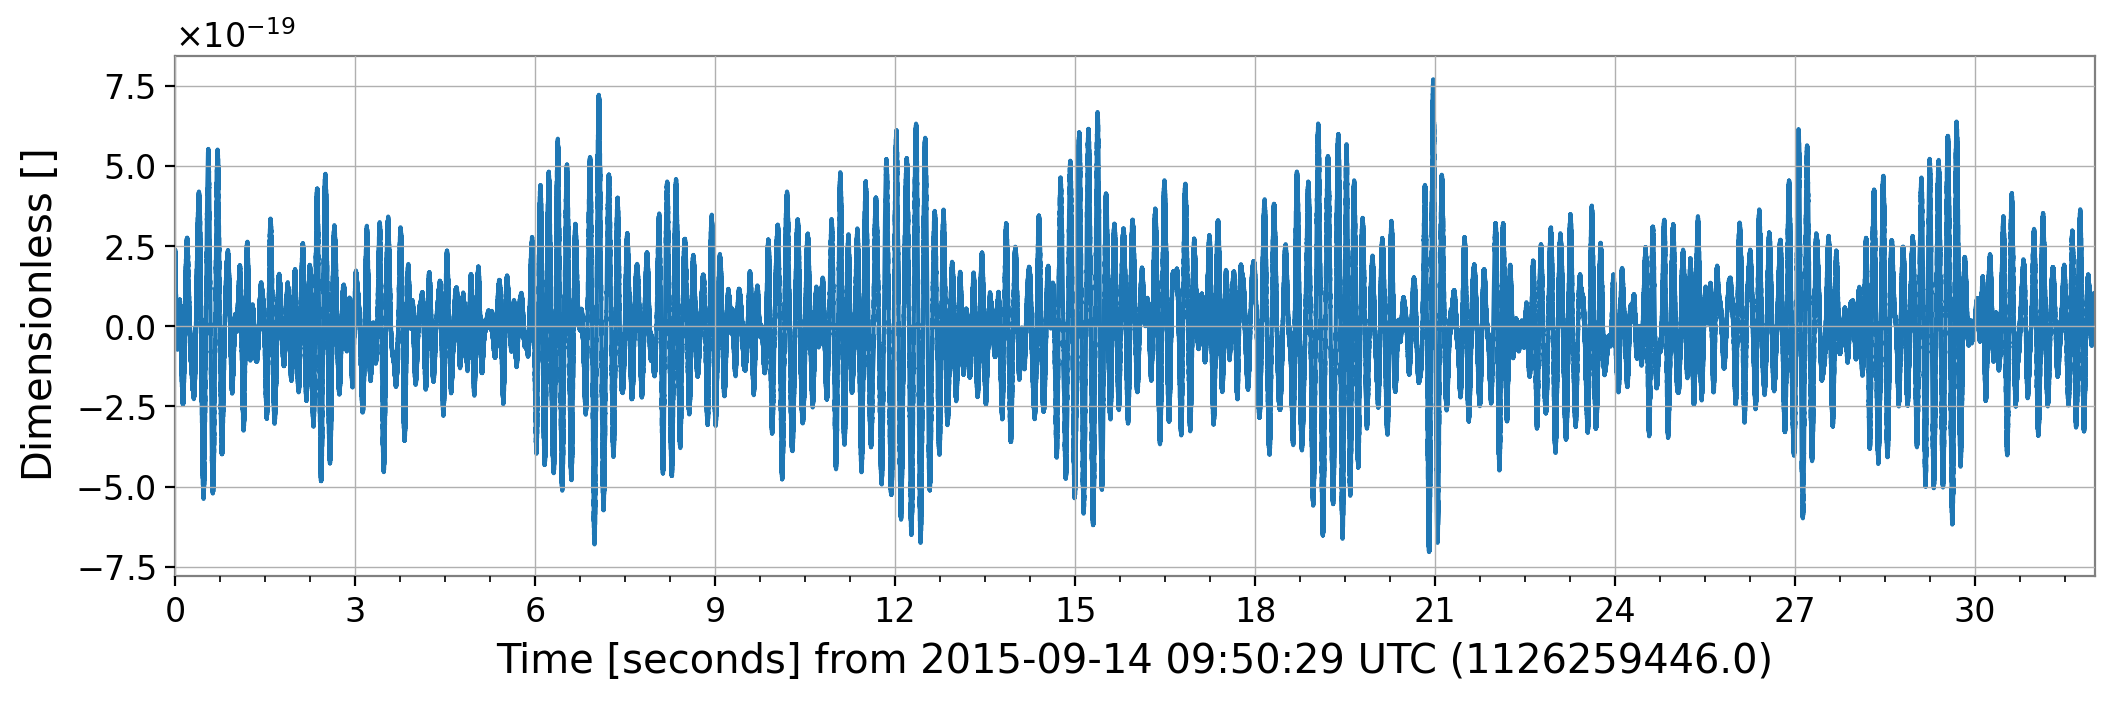

In [ ]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')
center = int(t0)
strain = strain.crop(center-16, center+16)
fig1 = strain.plot()

Apply some filters to the data

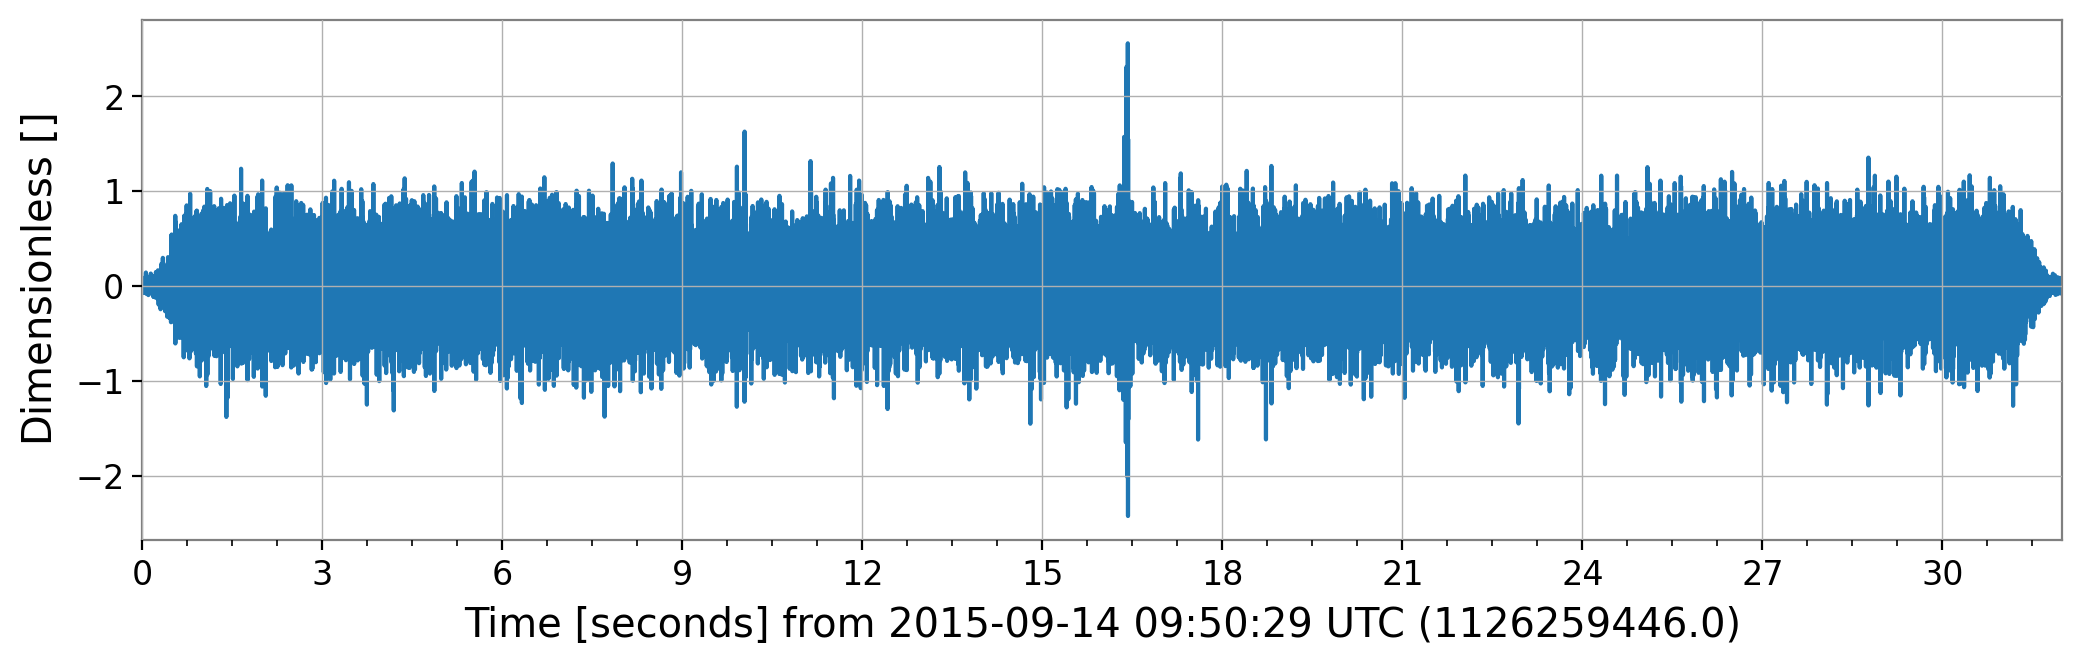

In [ ]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot(xscale=0)

Unmask the signal

(1126259462.1000001, 1126259462.7)

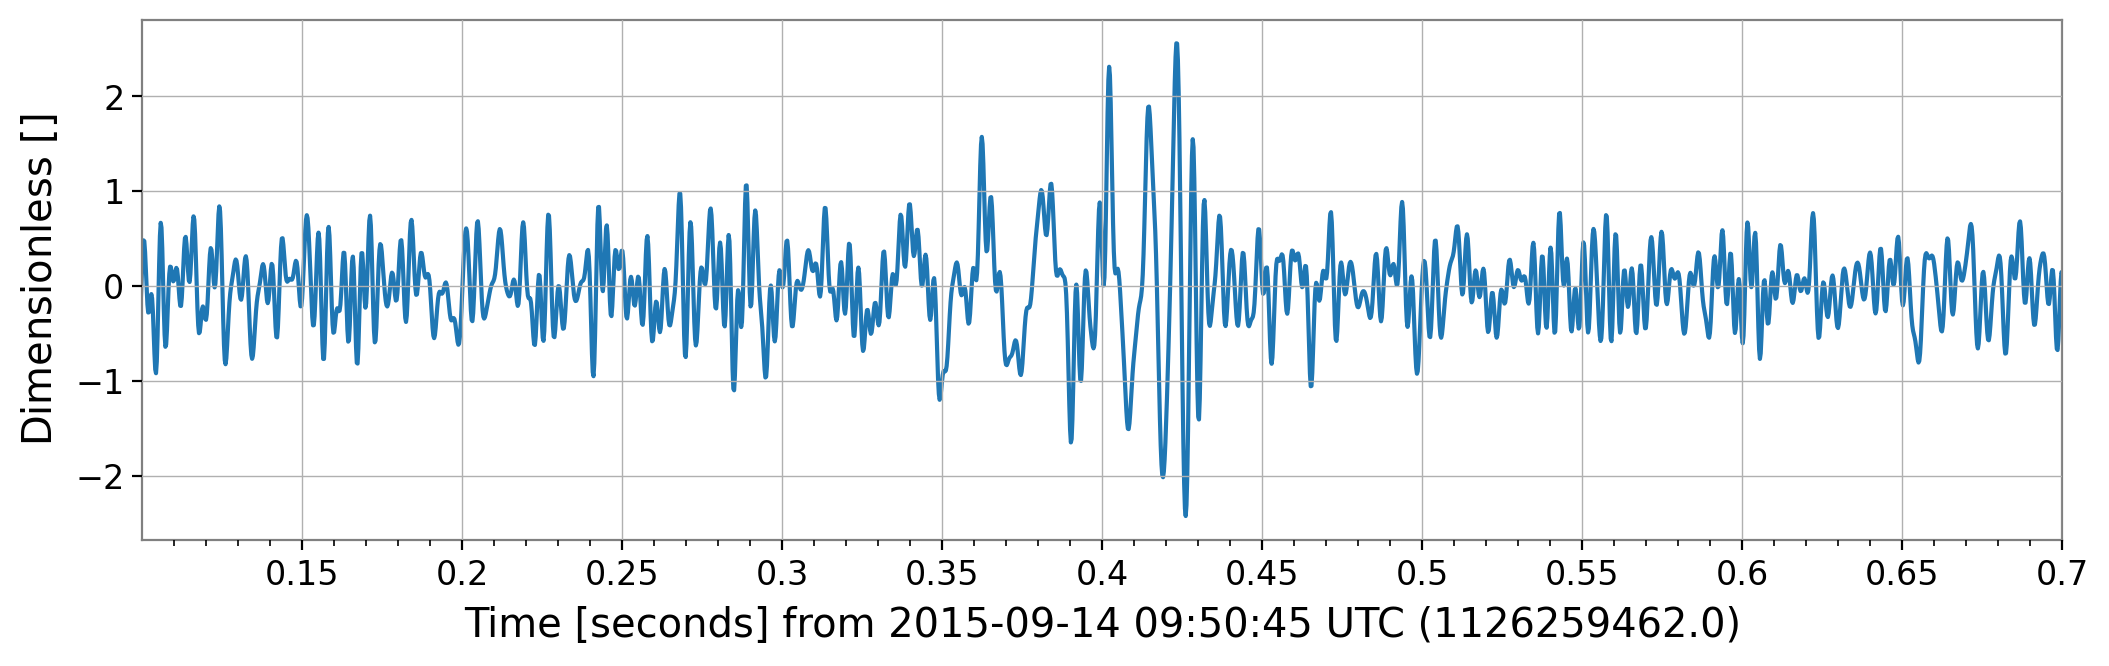

In [ ]:
fig3 = bp_data.plot(xscale=0)
plt.xlim(t0-.3, t0+.3)

To see it more clearly, and see the usual image, plot a q-transform of the data

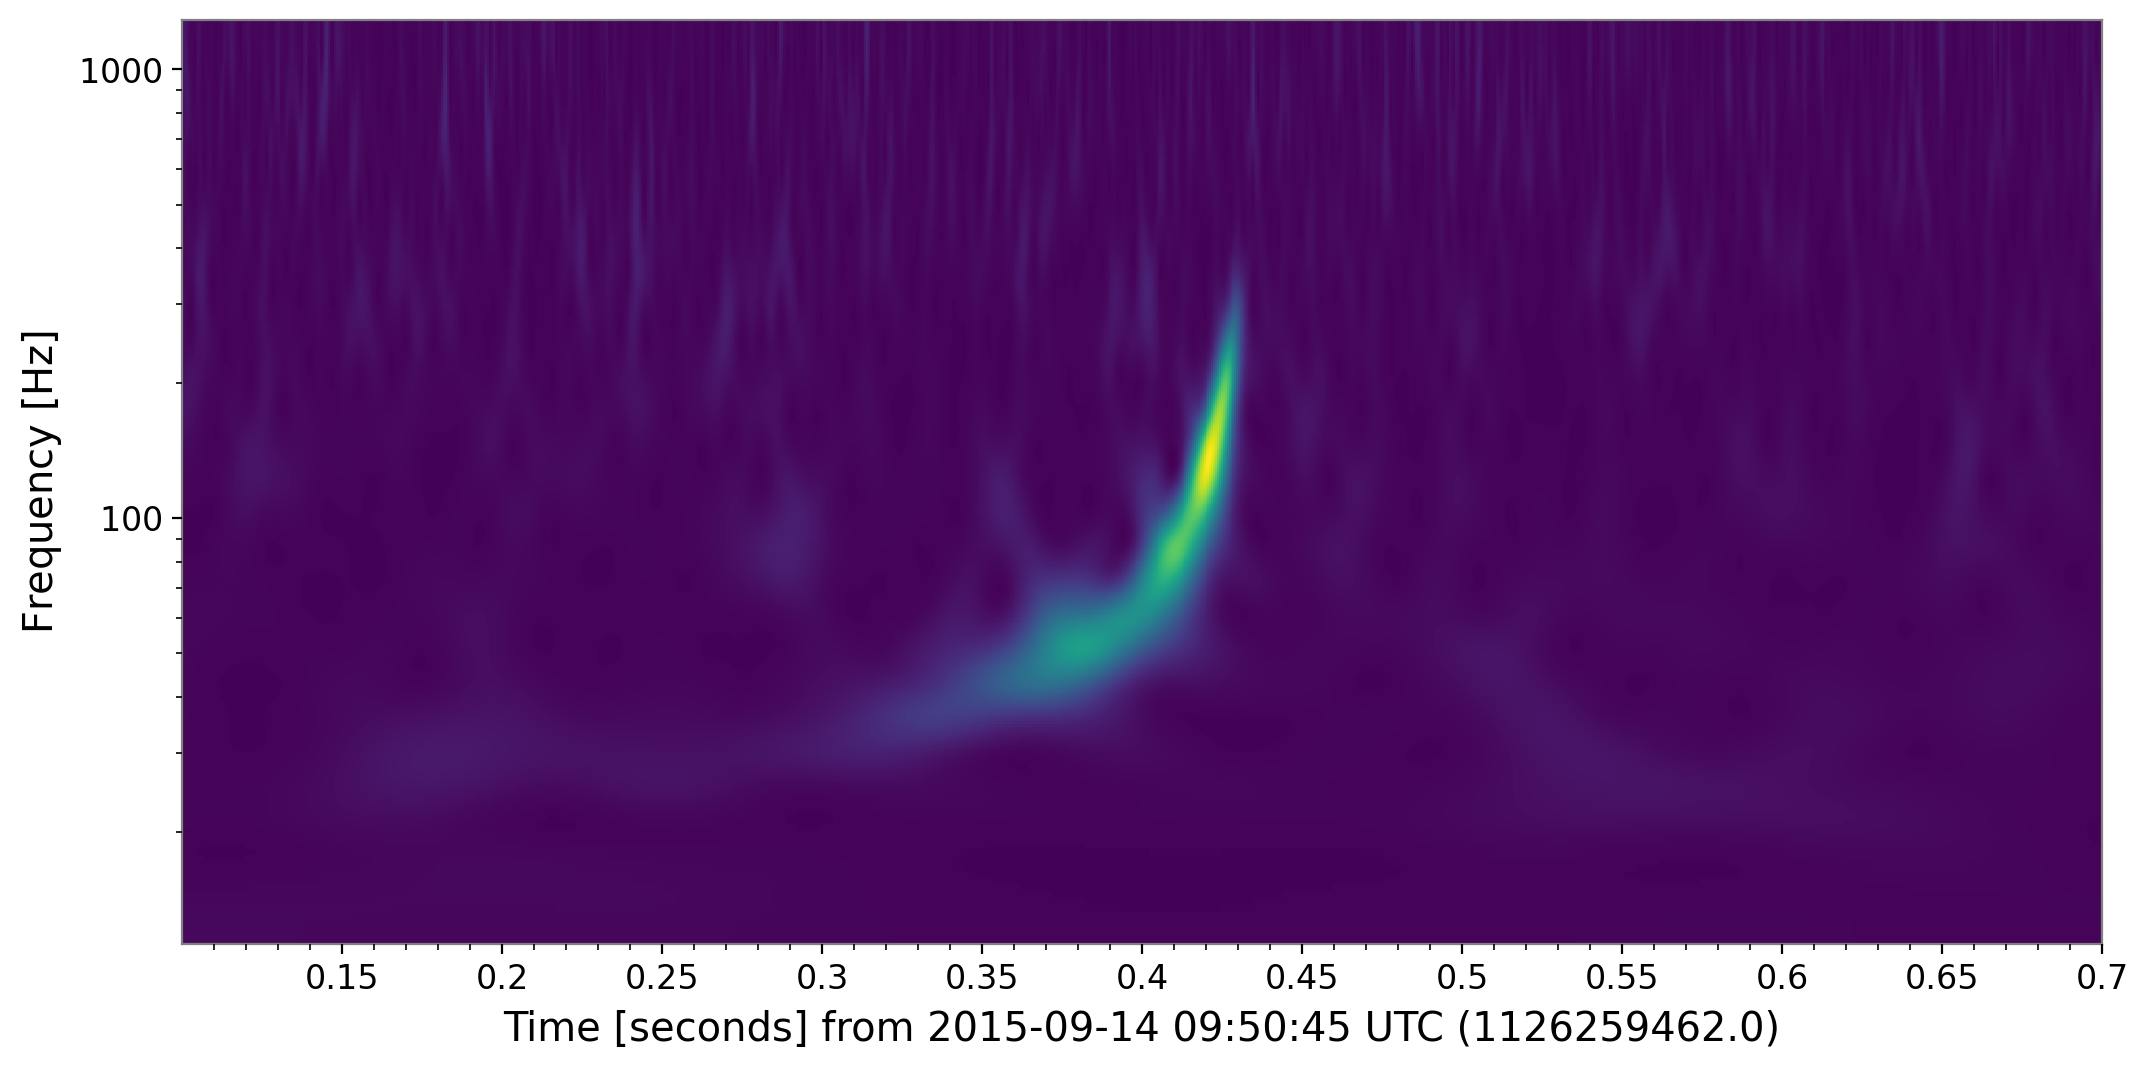

In [ ]:
dt = .3  #-- Set width of q-transform plot, in seconds
hq = bp_data.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
# fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')

---

## Pre-Processing

The following should be run just once, to get the data from LIGO and do all the pre-processing to it

Download relevant data ('confident' gws)

In [ ]:
def download(detector, t0s):
  for t0 in t0s:
    try:
      url = get_urls(detector, t0, t0)[-1]
    except:
      print(f'No signal found for t0:{t0} on detector {detector}')
      continue

    print('Downloading: ' , url)
    fn = os.path.basename(url)
    with open(fn,'wb') as strainfile:                 
        straindata = requests.get(url)
        strainfile.write(straindata.content)
    
    strain = TimeSeries.read(fn,format='hdf5.gwosc')
    center = t0
    strain = strain.crop(center-16, center+16)
    np.savetxt(f'raw/{detector}_{t0}.txt',np.array(strain))
    print(f'Succesfully saved raw data for t0: {t0}')

gwtc = pd.read_csv('confident.csv')
t0s = np.array(gwtc.GPS)

strains = download('H1',t0s)

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
Succesfully saved raw data for t0: 1126259462.4
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW151012/v3/H-H1_GWOSC_4KHZ_R1-1128676853-4096.hdf5
Succesfully saved raw data for t0: 1128678900.4
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW151226/v2/H-H1_GWOSC_4KHZ_R1-1135134303-4096.hdf5
Succesfully saved raw data for t0: 1135136350.6
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170104/v2/H-H1_GWOSC_4KHZ_R1-1167557889-4096.hdf5
Succesfully saved raw data for t0: 1167559936.6
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170608/v3/H-H1_GWOSC_4KHZ_R1-1180920447-4096.hdf5
Succesfully saved raw data for t0: 1180922494.5
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170729/v1/H-H1_GWOSC_4KHZ_R1-1185387760-40

Grab data that has been categorized as 'good'. This is based on the spectrograms shown on gwosc page.

In [ ]:
def gws_gps(which='G'):
  GBR = pd.read_csv('OndasGrav.csv',delimiter=';')
  
  if which == 'G':
    H1s = np.array( GBR['GPS'][np.where(GBR['H1'] == 'G')[0]] ) 
    L1s = np.array( GBR['GPS'][np.where(GBR['L1'] == 'G')[0]] )
    V1s = np.array( GBR['GPS'][np.where(GBR['V1'] == 'G')[0]] )
  else:
    # This is to take all the data, not just G
    H1s = np.array( GBR['GPS'][np.where(~GBR['H1'].isna())[0]] ) 
    L1s = np.array( GBR['GPS'][np.where(~GBR['L1'].isna())[0]] )
    V1s = np.array( GBR['GPS'][np.where(~GBR['V1'].isna())[0]] )

  return H1s, L1s, V1s

H1s, L1s, V1s = gws_gps()

Filter file for the timeframe where the gw is

In [ ]:
def gw_filter(t0,detector,dt=.000244140625): ############################################################
  ''' Filter data of the gw, centered aroud t0, window of 0.6s
  '''
  strain_np = np.loadtxt(f'raw/{detector}_{t0}.txt')
  strain = TimeSeries(strain_np,t0=0,dt=dt)
  white_data = strain.whiten()
  bp_data = white_data.bandpass(30, 400)
  gw = bp_data[int((16+t0%1 - .3)/dt):int((16+t0%1 + .3)/dt)] # account for the int(t0) when downloading data, center around t0
  np.savetxt(f'gws_all/{detector}_{t0}.txt',np.array(gw))
  print(f'Succesfully saved gw data for t0: {t0}')

# Do it for H, L, and V
for t0 in V1s:
  gw_filter(t0,'V1')

Create array with names of the files for the gws

In [ ]:
def gws_names(H1s,L1s,V1s):
  gws = np.empty(len(H1s)+len(L1s)+len(V1s),dtype='U20')
  i = 0
  for H1 in H1s:
    gws[i] = f'H1_{H1}'
    i+=1
  for L1 in L1s:
    gws[i] = f'L1_{L1}'
    i+=1
  for V1 in V1s:
    gws[i] = f'V1_{V1}'
    i+=1
  return gws

gws = gws_names(H1s,L1s,V1s)

Plot the strains

In [ ]:
# Save the plots of the gw strains
def plot_gw(t0):
  strain = np.loadtxt(f'gws_all/{t0}.txt')
  strain = TimeSeries(strain,t0=0,dt=.000244140625)
  fig3 = strain.plot(xscale=0)
  plt.title(f'{t0}')
  plt.xlim(0,0.6)
  plt.savefig(f'strains_all/{t0}.png')

for t0 in gws:
  plot_gw(t0)

In [ ]:
# In case a column with times is needed. tbs
def gws_4gan(t0):
  t = np.arange(0,0.6,.000244140625)
  strain = np.loadtxt(f'gws/{t0}.txt')
  joined = np.array((t,strain)).T
  pd.DataFrame(joined, columns=['t','strain']).to_csv(f'tgws/{t0}.txt')

In [ ]:
# Fix length of some gws, missing one value for some reason
def fix_length(gws):
  for gw in gws:
    strain = np.loadtxt(f'gws_all/{gw}.txt')
    if len(strain) != 2458:
      # print(f':( {gw}')
      strain = np.insert(strain,0,0)
      np.savetxt(f'gws_all/{gw}.txt',strain)

fix_length(gws)

In [ ]:
# the ones missing one value were the gws with gps time ending on .5 or .0 hm
for gw in gws:
  if gw[-1] == '0' or gw[-1] == '5':
    print(float(gw[3:])%1)

## Implementation of GAN

In [ ]:
# Set gws gps to take. In case previous cells weren't run

def gws_gps(which='G'):
  GBR = pd.read_csv('OndasGrav.csv',delimiter=';')
  
  if which == 'G':
    H1s = np.array( GBR['GPS'][np.where(GBR['H1'] == 'G')[0]] ) 
    L1s = np.array( GBR['GPS'][np.where(GBR['L1'] == 'G')[0]] )
    V1s = np.array( GBR['GPS'][np.where(GBR['V1'] == 'G')[0]] )
  else:
    # This is to take all the data, not just G
    H1s = np.array( GBR['GPS'][np.where(~GBR['H1'].isna())[0]] ) 
    L1s = np.array( GBR['GPS'][np.where(~GBR['L1'].isna())[0]] )
    V1s = np.array( GBR['GPS'][np.where(~GBR['V1'].isna())[0]] )
  return H1s, L1s, V1s

def gws_names(H1s, L1s, V1s):
  gws = np.empty(len(H1s)+len(L1s)+len(V1s),dtype='U20')
  i = 0
  for H1 in H1s:
    gws[i] = f'H1_{H1}'
    i+=1
  for L1 in L1s:
    gws[i] = f'L1_{L1}'
    i+=1
  for V1 in V1s:
    gws[i] = f'V1_{V1}'
    i+=1
  return gws

H1s, L1s, V1s = gws_gps(which='all')
gws = gws_names(H1s, L1s, V1s)

Data setup

In [ ]:
# Random seed for reproducibility
np.random.seed(17)
tf.random.set_seed(17)

# Constants
NUM_FILES = len(gws) # Number of gws available
NUM_SAMPLES = 2458 # Length of the gw data (0.6 seconds, at 4kH)
LATENT_DIM = 100 # Dimension of the vector of noise to be fed to the generator model
BATCH_SIZE = 32 # batch size. Might need tuning since large model and low data
EPOCHS = 500

# Load data
def load_data(gws):
  data = []
  for gw in gws:
    try:
      file_path = f'gws_all/{gw}.txt' # Path where the gw data is stored
      file_data = np.loadtxt(file_path)
      data.append(file_data)
    except:
      print('Nan')
  data = np.vstack(data)
  return data

data = load_data(gws)

# Separate in training and validation sets
data_train, data_test = train_test_split(data,test_size=.3,random_state=17)
print(data_train.shape, data_test.shape)

Nan
Nan
(165, 2458) (72, 2458)


Define structure and train GAN

In [ ]:
typ = 'Dense'

if typ == 'Dense':
  generator = keras.Sequential([
    layers.Dense(128, input_dim=LATENT_DIM),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Dense(512),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Dense(NUM_SAMPLES),
    layers.Reshape((NUM_SAMPLES, 1))], name='Generator')

  discriminator = keras.Sequential([
      layers.Input(shape=(NUM_SAMPLES, 1)),
      layers.Flatten(),
      layers.Dense(1024),
      layers.Dropout(.3),
      layers.LeakyReLU(alpha=0.2),
      layers.Dense(256),
      layers.Dropout(.3),
      layers.LeakyReLU(alpha=0.2),
      layers.Dense(64),
      layers.Dropout(.3),
      layers.LeakyReLU(alpha=0.2),
      layers.Dense(1, activation="sigmoid")], name='Discriminator')
  discriminator.compile(loss="binary_crossentropy", optimizer="adam")
else:
  generator = keras.Sequential([
      layers.Dense(128, input_dim=LATENT_DIM),
      layers.Dropout(.3),
      layers.LeakyReLU(alpha=0.2),
      layers.Reshape((1, 128)),

      layers.LSTM(256, return_sequences=True),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),

      layers.LSTM(512, return_sequences=True),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(NUM_SAMPLES),
      layers.Reshape((NUM_SAMPLES, 1))], name='Generator')

  discriminator = keras.Sequential([
      layers.Input(shape=(NUM_SAMPLES, 1)),
      layers.Conv1D(64, kernel_size=3, strides=1, padding='same'),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      layers.MaxPooling1D(pool_size=2),

      layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),
      layers.Dense(1, activation="sigmoid")], name='Discriminator')
  discriminator.compile(loss="binary_crossentropy", optimizer="adam")

# Set discriminator to non-trainable to be used in GAN
discriminator.trainable = False

# Define GAN model
gan = keras.Sequential([
    generator,
    discriminator], name='GAN')

gan.compile(loss="binary_crossentropy", optimizer="adam") #, metrics='accuracy')

# Generate noise samples for the generator
def generate_noise(n_samples, latent_dim):
    x = np.random.randn(n_samples, latent_dim)
    return x

# Generate real samples for the discriminator
def generate_real_samples(data, n_samples):
    idx = np.random.randint(0, data.shape[0], n_samples)
    x = data[idx]
    y = np.ones((n_samples, 1))
    return x, y

# Save the losses
def save_log(history):
  d = pd.DataFrame(history.T)
  d.columns = ['d_l','g_l','val_l']
  d.to_csv('checkpoints/all_LSTM/log.csv')

# Saving last version of the model. Again, should be callback to save best version
def save_model(gan,generator,discriminator):
  gan.save('checkpoints/all_LSTM/gan')
  generator.save('checkpoints/all_LSTM/gen')
  discriminator.save('checkpoints/all_LSTM/disc')


def train_gan(generator, discriminator, gan, data, val_data, latent_dim, num_epochs, batch_size):
    history = np.zeros((3,num_epochs))

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train discriminator
        x_real, y_real = generate_real_samples(data, batch_size)
        fake_samples = generator.predict(generate_noise(batch_size, latent_dim))
        
        # Train on real samples
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(x_real, y_real,)
        
        # Train on fake samples
        discriminator.trainable = True
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
        
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        
        # Train generator
        noise = generate_noise(len(data), latent_dim)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, np.ones((len(data), 1)))
        
        # Print losses
        print(f"Discriminator loss: {d_loss}")
        print(f"Generator loss and accuracy: {g_loss}")
        
        # Evaluate on validation data
        val_loss = discriminator.evaluate(val_data, np.ones((len(val_data), 1)), verbose=0)
        print(f"Validation loss: {val_loss}")
        history[:,epoch] = [d_loss, g_loss, val_loss] #g_loss[0], g_loss[1], val_loss]

        # Save the best model. Could be done with callbacks. Also consider different loss
        # if epoch==0:
        #   best_val = val_loss
        # else:
        #   if val_loss < best_val:
        #     best_val = val_loss
        #     save_model(gan,generator,discriminator)

    return history

# See the models structure
# discriminator.summary()
# generator.summary()
gan.summary()

Train the GAN

In [ ]:
# Train GAN
hist = train_gan(generator, discriminator, gan, data_train, data_test, LATENT_DIM, 95, BATCH_SIZE)

Epoch 1/95
1/1 [==============================] - 1s 978ms/step
Discriminator loss: 3.470105767250061
Generator loss and accuracy: 0.09258341789245605
Validation loss: 0.10818841308355331
Epoch 2/95
1/1 [==============================] - 0s 18ms/step
Discriminator loss: 5.911387920379639
Generator loss and accuracy: 0.09324409812688828
Validation loss: 0.13834401965141296
Epoch 3/95
1/1 [==============================] - 0s 20ms/step
Discriminator loss: 7.91928243637085
Generator loss and accuracy: 0.16601574420928955
Validation loss: 0.27878516912460327
Epoch 4/95
1/1 [==============================] - 0s 17ms/step
Discriminator loss: 7.934341907501221
Generator loss and accuracy: 0.3498143255710602
Validation loss: 0.5227037072181702
Epoch 5/95
1/1 [==============================] - 0s 16ms/step
Discriminator loss: 5.92426872253418
Generator loss and accuracy: 0.7365937232971191
Validation loss: 0.8063935041427612
Epoch 6/95
1/1 [==============================] - 0s 17ms/step
Discrim

Save model and its log. (should be done with a callback, no fit but train_on_batch so hm)

In [ ]:
save_log(history)
save_model(gan,generator,discriminator)

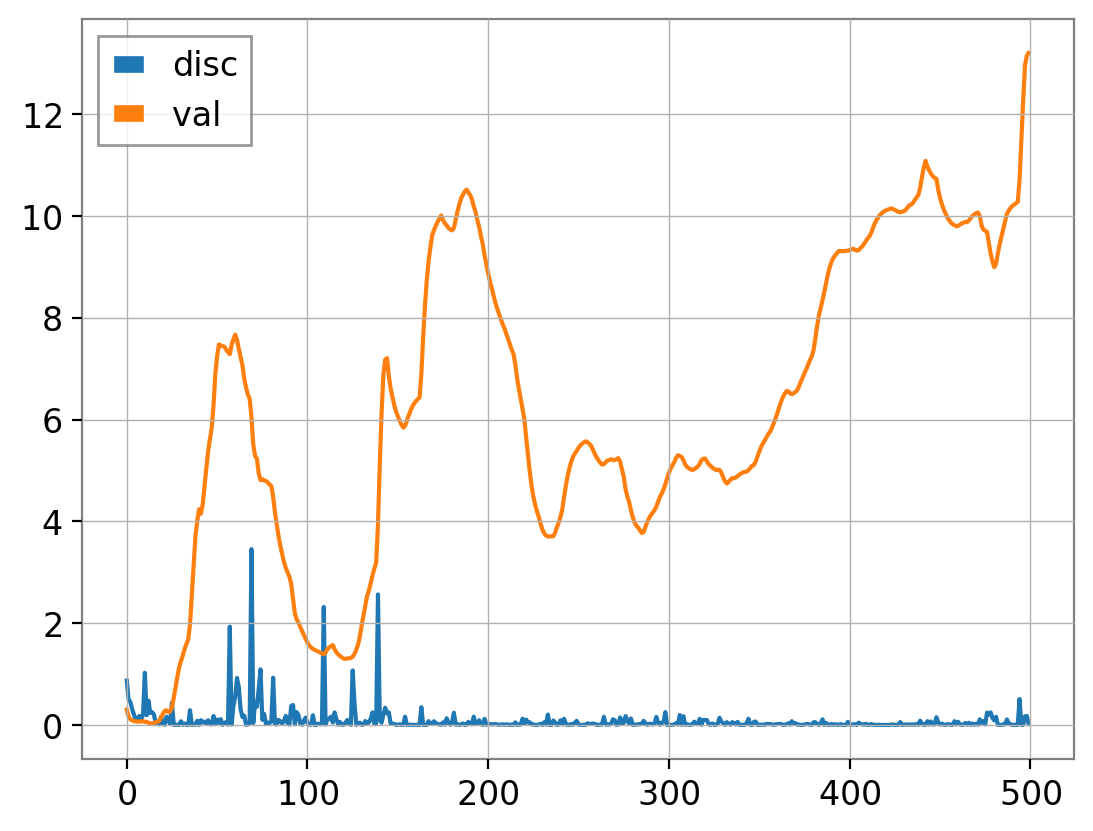

In [ ]:
plt.plot(range(500),history[0,:],label='disc')
plt.plot(range(500),history[1,:],label='gen')
plt.plot(range(500),history[2,:],label='val')
plt.legend()
plt.show()

Generate synthetic data

In [ ]:
n_samples = 10
synthetic_data = generator.predict(generate_noise(n_samples, LATENT_DIM))

def plot_synthetic_signals(signals):
  i=0
  for ss in signals:
    strain = np.reshape(ss,2458)
    np.savetxt(f'checkpoints/G_LSTM/synth/gws/{i}.txt',strain)
    strain = TimeSeries(strain,t0=0,dt=.000244140625)
    fig3 = strain.plot(xscale=0)
    plt.title(f'{i}')
    plt.xlim(0,0.6)
    plt.savefig(f'checkpoints/G_LSTM/synth/strains/{i}.png')
    i+=1

plot_synthetic_signals(synthetic_data)

Plot spectrograms for the synthetic signals

In [ ]:
# Plot spectrograms for the signals
def spectrograms(t0):
  dt = .000244140625

  lowar = np.random.randn(round(16/dt))/10
  uppr = np.random.randn(round(16/dt))/10


  data = np.loadtxt(f'gws_all/{t0}.txt')

  sdata = np.concatenate((lowar,data,uppr))

  st = TimeSeries(sdata,t0=0,dt=dt)

  hq = st.q_transform(outseg=(16,16.6))
  fig4 = hq.plot()
  ax = fig4.gca()
  # fig4.colorbar(label="Normalised energy")
  ax.grid(False)
  ax.set_yscale('log')

  fig4.savefig(f'specs/{t0}.png')


for t0 in gws:
  spectrograms(t0)

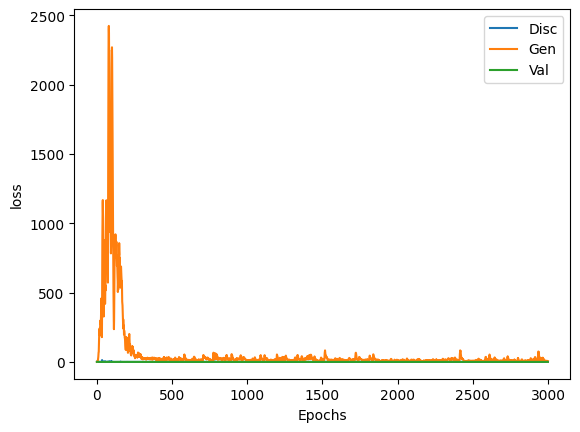

In [ ]:
history = np.array(pd.read_csv(f'checkpoints/all/log.csv'))

plt.plot(np.arange(history.shape[0]),history[:,1],label='Disc')
plt.plot(np.arange(history.shape[0]),history[:,2],label='Gen')
plt.plot(np.arange(history.shape[0]),history[:,3],label='Val')
plt.legend(loc='upper right')
# plt.yscale('log')
# plt.ylim(0,100)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.savefig('checkpoints/all/log.png',dpi=400)

plt.show()